<a href="https://colab.research.google.com/github/GiovanniMerici/Ancestral-Reconstruction/blob/main/Grasp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Install Libraries
!apt-get update
!apt-get install -y raxml
!apt-get install -y mafft
!apt-get update -qq
!apt-get install -y openjdk-8-jdk-headless
!wget https://github.com/ddarriba/prottest3/releases/download/3.4.2-release/prottest-3.4.2-20160508.tar.gz
!tar -xzf prottest-3.4.2-20160508.tar.gz
!mv prottest-3.4.2 prottest3
!wget https://bodenlab.github.io/GRASP-suite/project/graspcmd/archive/bnkit_legacy.jar
script = '''
#!/bin/sh
java -jar -Xmx16g bnkit_legacy.jar $@
'''
with open('grasp','w') as grasper:
  grasper.write(script)
!chmod 755 grasp
!mv grasp /usr/local/bin
!pip install biopython

import glob
import os
from Bio import Phylo, AlignIO, SeqIO
import pandas as pd
from Bio.Align import MultipleSeqAlignment
import subprocess

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,609 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,163 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8

In [ ]:
# @title Function

def short_prottest():
  starterlist= ['Best model according to AIC:','Best model according to BIC:']

  with open(f'{folder_name}/prottest_results.txt','r') as file:
    lines =  file.readlines()
    for line in lines:
      for starter in starterlist:
        if line.startswith(f'{starter}'):
          with open(f'{folder_name}/prottest_results_short.txt','a') as short:
            short.write(line)
  with open(f'{folder_name}/prottest_results_short.txt','r') as short:
    lines = short.readlines()
    for line in lines:
      if line.startswith(f'{starterlist[1]}'):
        model = line.split(': ')[1].strip()

  return model

def tree_processor():
  tree1 = Phylo.read(f'{tree}','newick')
  tree1.root_at_midpoint()
  Phylo.draw(tree1)
  Phylo.write(tree1,f"{folder_name}/{os.path.basename(tree.split('.')[0])}_rooted.nwk",'newick')
  return

def alignment_sweeper():
  gap = '-'
  gap_list = []
  records = list(AlignIO.read(f"{alignment}", "fasta"))
  for rec in records:
    gap_count = 0
    for aa in rec.seq:
      if aa == gap:
        gap_count += 1

    gap_per = gap_count/len(rec.seq)
    gap_list.append([gap_count,gap_per, rec.id])


  df = pd.DataFrame(gap_list)
  df_cleaned = df[(df[1] > (df[1].mean() - df[1].std())) & (df[1] < (df[1].mean() + df[1].std()))]
  keepa = []
  sequences = list(SeqIO.parse(f"{fasta}", "fasta"))
  for sequence in sequences:
    for id_ in df[2]:
      if sequence.id == id_:
        if 'X' in sequence.seq:
          sequence.seq = sequence.seq.replace('X','G')
        if 'B' in sequence.seq:
          sequence.seq = sequence.seq.replace('B','D')
        if 'Z' in sequence.seq:
          sequence.seq = sequence.seq.replace('Z','E')

        keepa.append(sequence)
        break
  print(keepa)

  SeqIO.write(keepa,f"{fasta.split('.')[0]}_cleaned.fa",'fasta')
  return df, df_cleaned

def tree_grasp():
  tree_grasp = Phylo.read(f'{folder_name}/grasp_tree.nwk','newick')
  Phylo.draw(tree_grasp)
  return tree_grasp

prottest_to_raxml = {
    "JTT": "PROTGAMMAJTT",
    "LG": "PROTGAMMALG",
    "LG+G": "PROTGAMMALG",
    "WAG": "PROTGAMMAWAG",
    "Blosum62": "PROTGAMMABLOSUM62",
    "Dayhoff": "PROTGAMMADAYHOFF",
    "DCMut": "PROTGAMMADCMUT",
    "MtREV": "PROTGAMMAMTREV",
    "VT": "PROTGAMMAVT",
    "CpREV": "PROTGAMMACPREV",
    "RtREV": "PROTGAMMARTREV",
    "FLU": "PROTGAMMAFLU",
    "HIVb": "PROTGAMMAHIVB",
    "HIVw": "PROTGAMMAHIVW",
    "JTTDCMut": "PROTGAMMAJTTDCMUT",
    "LG+F": "PROTGAMMALGF",
    "LG+G+F": "PROTGAMMALGF",
    "WAG+F": "PROTGAMMAWAGF",
    "JTTDCMut+F": "PROTGAMMAJTTDCMUTF",
}

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 10
done.

Constructing a UPGMA tree (efffree=0) ... 
    0 / 10
done.

Progressive alignment 1/2... 
STEP     9 / 9  f
done.

Making a distance matrix from msa.. 
    0 / 10
done.

Constructing a UPGMA tree (efffree=1) ... 
    0 / 10
done.

Progressive alignment 2/2... 
STEP     9 / 9  f
done.

disttbfast (aa) Version 7.490
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions than previous versions.
To disable this change, add the --leavegappyr

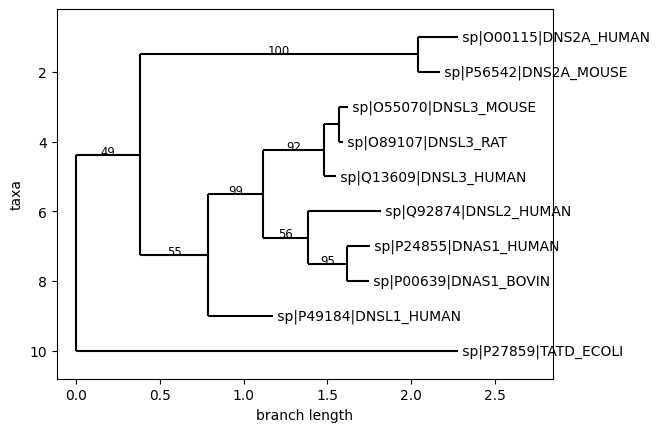

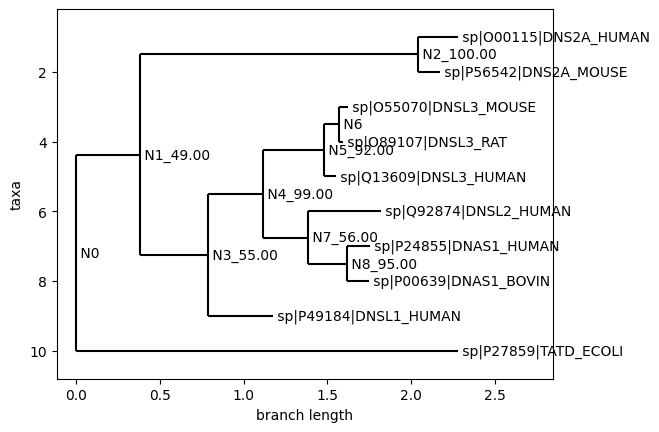

In [ ]:
# @title GRASP
folder_name = 'Ancestral' # @param {type:"string"}
fasta_file = 'seq.fa' # @param {type:"string"}

if os.path.exists(f'{folder_name}'):
    print(f"Directory {folder_name}  already exists.")
else:
    os.mkdir(f"{folder_name}")

!mv {fasta_file} {folder_name}/{fasta_file}

folder = glob.glob(f'{folder_name}/{fasta_file}')
fasta = folder[0]

alignment = f"{fasta.split('.')[0]+'.aln'}"
tree = f"{fasta.split('.')[0]+'.nwk'}"

!mafft {fasta} > {alignment}

df, df_cleaned = alignment_sweeper()

!mafft {fasta.split('.')[0]}_cleaned.fa > {alignment.split('.')[0]}_cleaned.aln

!java -jar prottest3/prottest-3.4.2.jar -i {alignment.split('.')[0]}_cleaned.aln -all-distributions -F -AIC -BIC -o {folder_name}/prottest_results.txt

model  = short_prottest()
if '+' in model:
  model = model.split('+')[0]

!raxmlHPC  -f a -x 12345 -N 100 -s {alignment.split('.')[0] + '_cleaned.aln'} -n {os.path.basename(tree)} -m {prottest_to_raxml.get(model)} -p 12345

!mv {'RAxML_bipartitions.'+os.path.basename(tree)} {tree}

tree1 = tree_processor()

!grasp -aln {alignment.split('.')[0]}_cleaned.aln -nwk {folder_name}/{os.path.basename(tree.split('.')[0])}_rooted.nwk -joint -savetree {folder_name}/grasp_tree.nwk -out {folder_name}/grasp_results.txt

tree_grasp = tree_grasp()